In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import corner
import json
import pandas as pd

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply

from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import infer
# from pyhf_pymc import one_line_inference
from pyhf_pymc import make_op
from pyhf_pymc import plotting

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import logging
logger = logging.getLogger('pymc')
logger.setLevel(logging.ERROR)

In [3]:
blue = '#1F449C'
orange = '#E57A77'
plt.rc('font', size=18)      
plt.rc('axes', titlesize=18)   
plt.rc('axes', labelsize=18)   
plt.rc('xtick', labelsize=18)   
plt.rc('ytick', labelsize=18)    
plt.rc('legend', fontsize=15)    
plt.rc('figure', titlesize=18)

## Model

In [23]:
nBins = 3
model = pyhf.simplemodels.correlated_background([10,15,20],[50,40,30],[55, 45, 35],[45, 35, 25])

unconstr_priors = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}

data = [60, 55, 50]
truth = [0., 1.]

prior_dict = prepare_inference.prepare_priors(model, unconstr_priors)
prepared_model = prepare_inference.prepare_model(model=model, observations=data, priors=prior_dict)

expData_op = make_op.make_op(model)

In [18]:
# with open('SRee_SRmm_Srem.json') as serialized:
with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()

data = workspace.data(model, include_auxdata=False)

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_priors = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[10], [10]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_priors)

    # dictionary with keys 'model', 'obs', 'priors', 'precision'
prepared_model = prepare_inference.prepare_model(model=model, observations=data, priors=prior_dict)

In [19]:
with infer.model(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=100, chains=1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(100)

Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 74 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


### Prior and Posterior Predictives

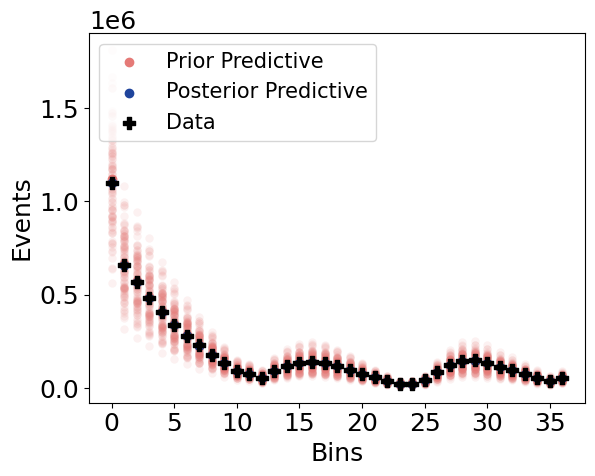

In [20]:
plotting.prior_posterior_predictives(model=model, data=data, post_pred=post_pred, prior_pred=prior_pred, bin_steps=5)

Text(0, 0.5, 'Events')

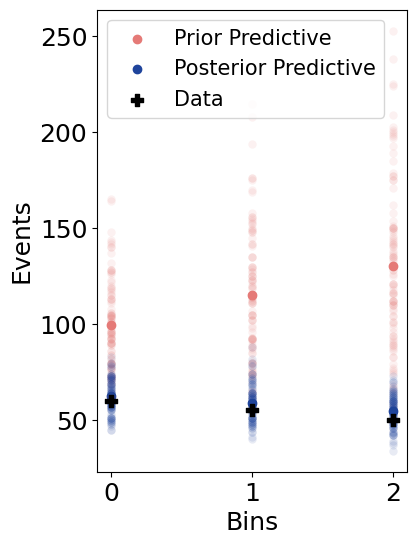

In [51]:
nBins = len(model.expected_actualdata(model.config.suggested_init()))
bin_steps = 1

# Build means
prior_means = []
post_means = []
for i in range(nBins):
    prior_means.append(prior_pred.prior_predictive.Expected_Data[0].T[i].mean())
    post_means.append(post_pred.posterior_predictive.Expected_Data[0].T[i].mean())

# Plot means
plt.figure(figsize=(4, 6))
plt.scatter(np.linspace(0,nBins-1,nBins), prior_means, color=orange, label='Prior Predictive')
plt.scatter(np.linspace(0,nBins-1,nBins), post_means, color=blue, label='Posterior Predictive')

# Plot samples
for i in range(nBins):
    plt.scatter(np.full(len(prior_pred.prior_predictive.Expected_Data[0].T[i]), i), prior_pred.prior_predictive.Expected_Data[0].T[i], alpha=0.1, color=orange, linewidths=0)
    plt.scatter(np.full(len(post_pred.posterior_predictive.Expected_Data[0].T[i]), i), post_pred.posterior_predictive.Expected_Data[0].T[i], alpha=0.1, color=blue, linewidths=0)

# Plot data
plt.scatter(np.arange(nBins), data, marker='P', c = 'k',s=70, zorder = 999, label = "Data")

plt.legend(loc='upper left')
plt.xticks(np.arange(0, nBins, bin_steps))
plt.xlabel('Bins')
plt.ylabel('Events')

### Corner Plots

In [43]:
with infer.model(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(10_000, chains = 1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(10_000)

Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 1 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


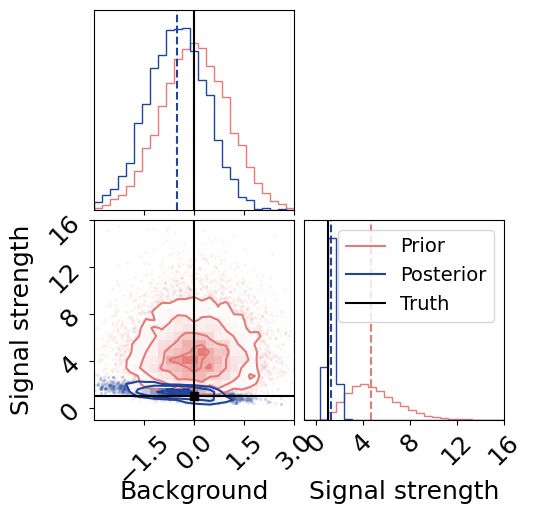

In [44]:
my_bins = [25, 25]
import matplotlib.lines as mlines

my_range = [[-3, 3], [-1, 16]]

a = corner.corner(prior_pred.prior, quantiles=[0.5], show_titles=True, title_fmt=None, color=orange, labels=['', ''], bins=my_bins, range=my_range)
corner.corner(post_data.posterior, quantiles=[0.5], color = blue, truths=[0., 1.], truth_color='black', bins=my_bins, fig=a, labels=['Background', 'Signal strength'], range=my_range)
plt.legend(handles=[
            (mlines.Line2D([], [], color=orange, label='Prior')),
            (mlines.Line2D([], [], color=blue, label='Posterior')),
            (mlines.Line2D([], [], color='black', label='Truth'))
            
        ], loc="upper right", fontsize=14)
# a.suptitle('Prior and Posterior Parameter Distributions')

### Calibration

In [50]:
with infer.model(model, unconstr_priors, data):
    step = pm.Metropolis()
    prior_pred = pm.sample_prior_predictive(10)

prior_Normals, prior_Unconstrained, prior_data = np.concatenate(prior_pred.prior.Normals[0]), np.concatenate(prior_pred.prior.Unconstrained[0]), np.array(prior_pred.prior_predictive.Expected_Data[0])

# with open('prior_Normals_Metropolis.txt', 'w') as filehandle:
#     json.dump(prior_Normals.tolist(), filehandle)
# with open('prior_Unconstrained_Metropolis.txt', 'w') as filehandle:
#     json.dump(prior_Unconstrained.tolist(), filehandle)

Sampling: [Expected_Data, Normals, Unconstrained]


In [ ]:
prior_dict = prepare_inference.prepare_priors(model, unconstr_priors)
prepared_model = prepare_inference.prepare_model(model=model, observations=data, priors=prior_dict)

post_Normals, post_Unconstrained, post_data = plotting.calibration(prepared_model, prior_pred)
# with open('post_Normals_Metropolis.txt', 'w') as filehandle:
#     json.dump(post_Normals.tolist(), filehandle)
# with open('post_Unconstrained_Metropolis.txt', 'w') as filehandle:
#     json.dump(post_Unconstrained.tolist(), filehandle)


# post_Normals, post_Unconstrained, post_data = [], [], []
# i = 0
# for p_d in prior_data:
#     a, b, c = posterior_from_prior(p_d)
#     post_Normals.append(a[0])
#     post_Unconstrained.append(b[0])
#     post_data.append(c[0])

#     # with open('post_Normals_Metropolis.txt', 'a') as file:
#     #     file.write(f'{post_Normals[i]}, ')

#     # with open('post_Unconstrained_Metropolis.txt', 'a') as file:
#     #     file.write(f'{post_Unconstrained[i]}, ')

#     print(f'STEP: {i}')
    # i += 1

From previous calibration:

In [4]:
prior_Normals = np.array(pd.read_csv('prior_Normals_Metropolis.txt', header=None))[0]
prior_Unconstrained = np.array(pd.read_csv('prior_Unconstrained_Metropolis.txt', header=None))[0]

post_Normals = np.array(pd.read_csv('post_Normals_Metropolis.txt', header=None))[0].tolist()
post_Normals.remove(' ')
post_Unconstrained = np.array(pd.read_csv('post_Unconstrained_Metropolis.txt', header=None))[0].tolist()
post_Unconstrained.remove(' ')

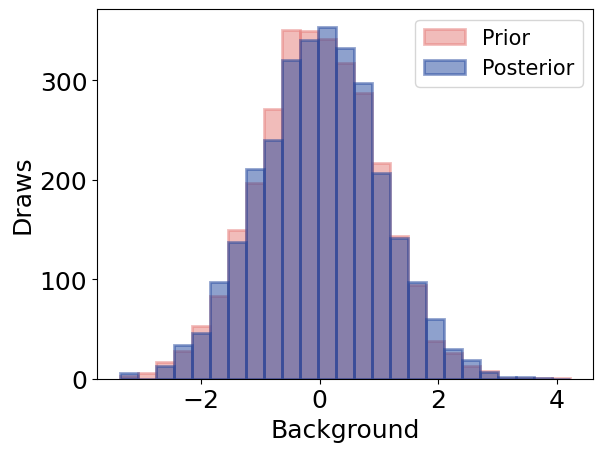

In [8]:
# Plot Normals
plt.hist(prior_Normals, 25, alpha = 0.5, color=orange, linewidth=2, label='Prior', edgecolor=orange)
_, bins, _ = plt.hist(prior_Normals, bins=25, histtype='step', color=orange, alpha=0.000001)
plt.hist(post_Normals, bins = bins, alpha = 0.5, color=blue, linewidth=2, label='Posterior', edgecolor=blue)
plt.xlabel('Background')
plt.ylabel('Draws')

plt.legend()


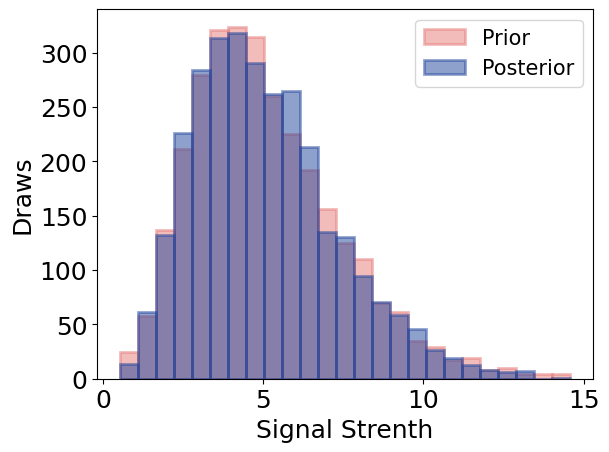

In [6]:
# Plot Unconstrained 
plt.hist(prior_Unconstrained, 25, alpha = 0.5, color=orange, linewidth=2, label='Prior', edgecolor=orange)
_, bins, _ = plt.hist(prior_Unconstrained, bins=25, histtype='step', color=orange, alpha=0.000001)
plt.hist(post_Unconstrained, bins=bins, alpha = 0.5, color=blue, linewidth=2, label='Posterior', edgecolor=blue)
plt.xlabel('Signal Strenth')
plt.ylabel('Draws')

plt.legend()

plt.show()

### Autocorrelation

Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (100) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Sampling 1 chain for 1_000 tune and 1_200 draw iterations (1_000 + 1_200 draws total) took 0 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (1200) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (100) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 600 draw iterations (1_000 + 600 draws total) took 1 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (600) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


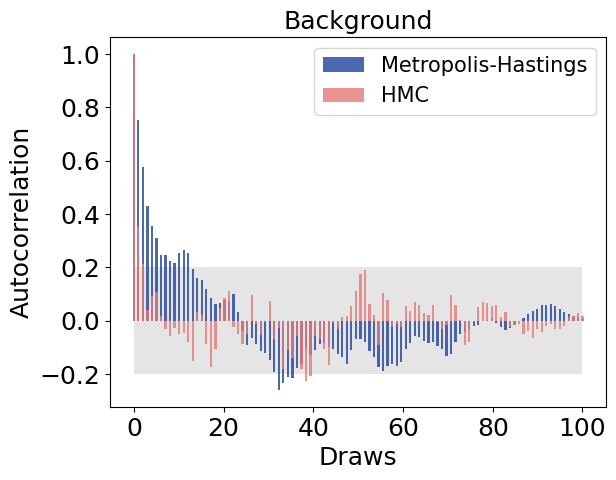

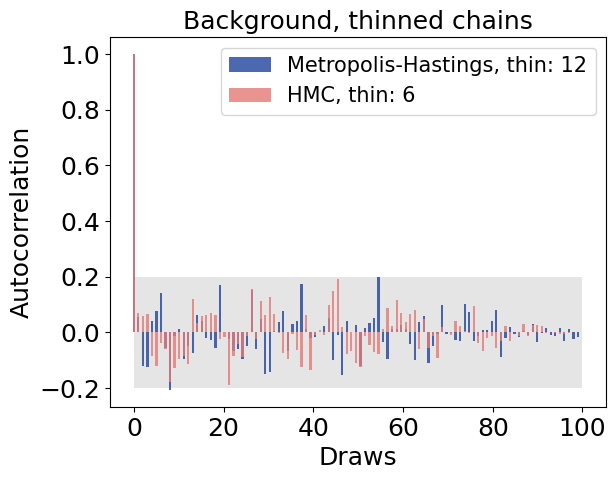

In [24]:
plotting.plot_autocorrelation(model, unconstr_priors, data=data)

## From Scratch Priors

### With initial updating

In [37]:
with pm.Model():
    pars = prepare_inference.priors2pymc(prepared_model)
    Expected_Data = pm.Poisson("Expected_Data", mu=expData_op(pars), observed=data)

    step = pm.Metropolis()

    post_data = pm.sample(draws=100, chains=1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(100)

Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


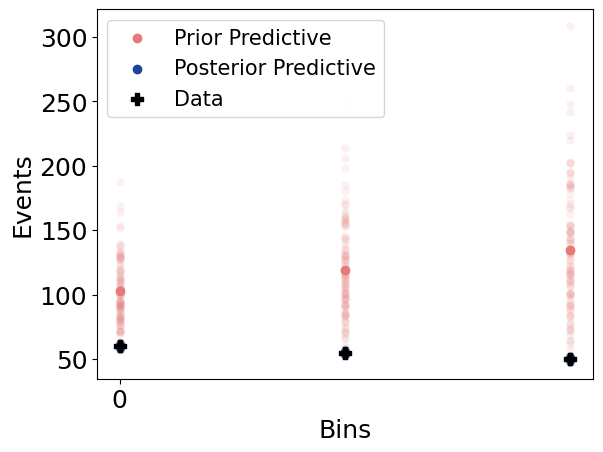

In [36]:
plotting.prior_posterior_predictives(model=model, data=data, post_pred=post_pred, prior_pred=prior_pred, bin_steps=3)

### W/o intitial updating

In [31]:
model.config.par_map

{'correlated_bkg_uncertainty': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x2d4a66520>},
 'mu': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x2d4a66550>}}

In [26]:
expAuxData_op = make_op.make_ActAux_op(model)

In [33]:
data_with_aux = [60, 55, 50, 0]

with pm.Model():
    pars = [pm.Normal(f"bkg", mu=0, sigma=1)]
    pars.append(pm.Gamma("mu", alpha=5., beta=1.))
    pars = pt.as_tensor_variable(pars)
    # pm.Poisson breaks doen for the aux-data (need to combine Poisson for actual and Normal for aux)
    Expected_Data = pm.Normal("Expected_Data", mu=expAuxData_op(pars), observed=data_with_aux)

    step = pm.Metropolis()

    post_data_with_aux = pm.sample(draws=100, chains=1, step=step)
    post_pred_with_aux = pm.sample_posterior_predictive(post_data_with_aux)
    prior_pred_with_aux = pm.sample_prior_predictive(100)

Only 100 samples in chain.


Sampling: [Expected_Data, bkg, mu]


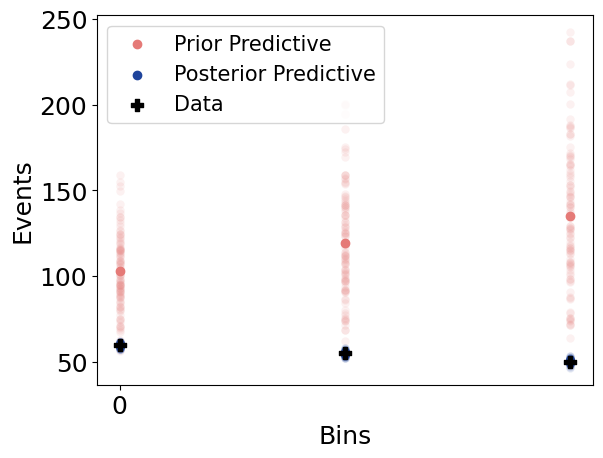

In [34]:
plotting.prior_posterior_predictives(model=model, data=data, post_pred=post_pred_with_aux, prior_pred=prior_pred_with_aux, bin_steps=3)